# Sklearn Workshop 1: Loan Prediction

- Prepare you for project
- We shall go through 3 case studies this week

Announcement:
- Next next week Friday we will meet, and we shall study how to deploy model to FastAPI
- Next next week Saturday no class -> project time
- Next next week Sunday: Presentation 9:00 - 12:00 - Each person 15 mins.

# Let's code!!

In [1]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt

## 1. Load the data

In [2]:
#get the data from google classroom
df_train = pd.read_csv("data/train_LoanPrediction.csv")
df_test  = pd.read_csv("data/test_LoanPrediction.csv")

In [3]:
#1. get the shape (rows, columns)
df_train.shape  #(614 rows, 13 columns)

#2. try .head()
df_train.head()

#3. try .describe()
df_train.describe()

#4. check whether our data class is balanced, using value_counts(normalize=True)
df_train['Loan_Status'].value_counts() #if you don't put normalize=True, will give you raw number

#our class is imbalanced....
#it means, we have to downsample Y, to equal N

Y    422
N    192
Name: Loan_Status, dtype: int64

### 1.1 Make the dataset valid

- this is not related to cleaning....this is about making the dataset valid....
- please help me downsample Y
- we only need to downsample the training set....because the training set is USED for training
- imbalanced class only affects the model during training


In [4]:
#1. set the cond = Y, and cond = N
condY = df_train.Loan_Status == 'Y'  #to 0 or 1
condN = df_train.Loan_Status == 'N'

#2.. df[condY].sample(n = 192)
#    df[condN].sample
#    we do this many times, do whole ML thing, and do the average....
df_trainY = df_train[condY].sample(n=192, random_state=999)
df_trainN = df_train[condN] #also 192

#3. concat these two dfs
df_train = pd.concat([df_trainY, df_trainN])

df_train.Loan_Status.value_counts()


Y    192
N    192
Name: Loan_Status, dtype: int64

### 2. EDA (Exploratory Data Analysis)
- What is the goal of EDA?
  - To identify promising features (e.g., ApplicantIncome) to predicting the target (e.g., Loan Status)

In [5]:
#0. Check the data type
df_train.dtypes
df_train.drop(columns = ['Loan_ID'], inplace=True)  #this is not a useful feature....
df_train.columns

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

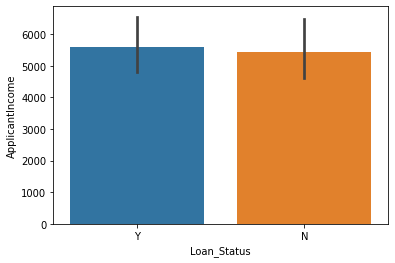

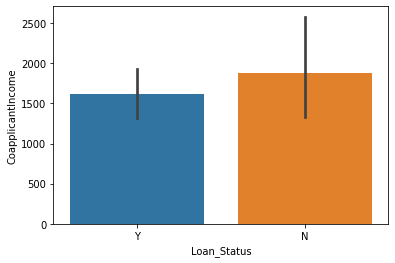

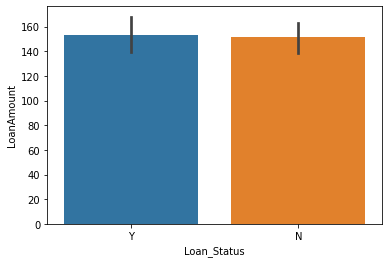

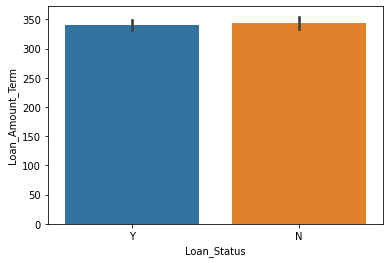

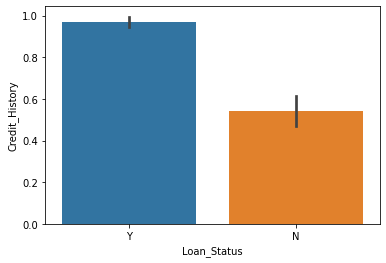

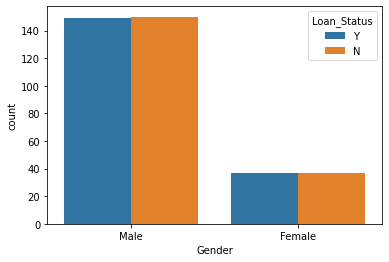

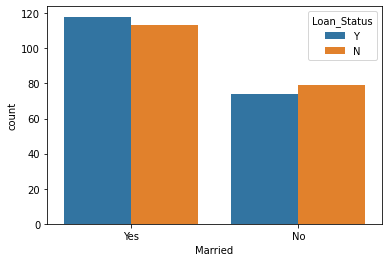

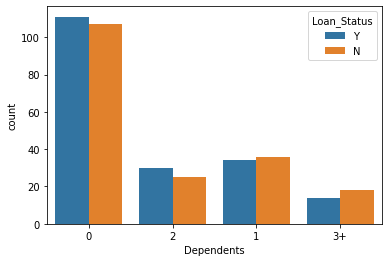

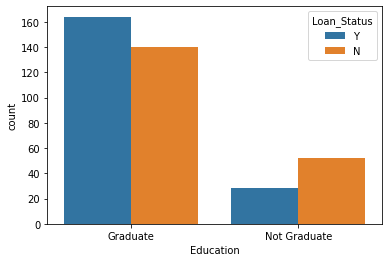

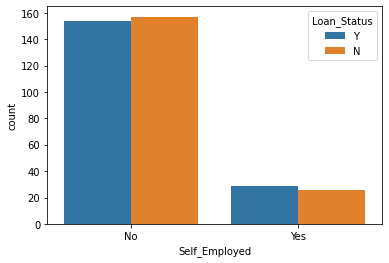

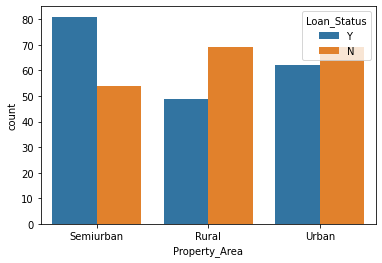

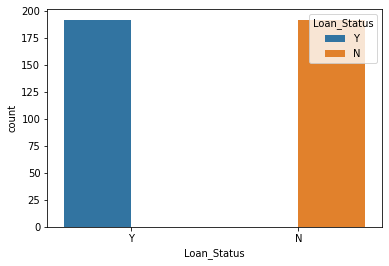

In [6]:
import seaborn as sns

#1. You want to divide into categorical and numerical columns using select_dtypes
df_train.dtypes
num_col = df_train.select_dtypes(include=['int64', 'float64'])
cat_col = df_train.select_dtypes(exclude=['int64', 'float64'])
num_col.columns, cat_col.columns

#2. for numerical type, please do a bar plot with Loan Status
for col in num_col.columns:
    sns.barplot(x = df_train['Loan_Status'], y = df_train[col])
    plt.show()

#3. for categorial type, you may want to use countplot with Loan Status
for col in cat_col.columns:
    sns.countplot(x = df_train[col], hue = df_train['Loan_Status'])
    #similar to hue in scatterplot
    plt.show()
    # sns.countplot()  #because categorical, you need to count, not simply use the magnitude...so cannot use bar...

In [7]:
df_train.columns

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [8]:
df_train.Loan_Status.unique()

array(['Y', 'N'], dtype=object)

I want to know the mapping of 0 and 1 ['N' 'Y']


<AxesSubplot:>

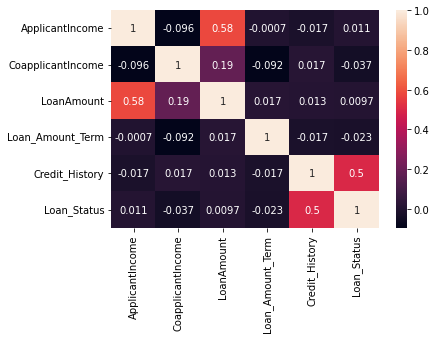

In [9]:
#4. try to do correlation 
#do label encoding the Loan Status
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_train['Loan_Status'] = le.fit_transform(df_train['Loan_Status'])

#very interesting...our testing set has no loan status, because this is actually a real testing set....

print("I want to know the mapping of 0 and 1", le.inverse_transform([0, 1]))

sns.heatmap(df_train.corr(), annot=True)  #this is only for numeric values....

#Your exercise:  i want you to see which features are useful....
#Credit History, Education, Property Area

#Break until 19:30  

# 3. Feature Extraction

- Remind you guys: we have to split first, then perform cleaning, standardization, etc....
- If not, the information from the testing set may flow to training set, so we want to set aside...

In [10]:
#fortunately, we can skip this step, because
#we already have df_train which is already a training set....

# 4. Cleaning, Standardization, Encoding

- cleaning: filling missing values
- encoding: changing str to int, or change the type of the column, etc.
- standardization: StandardScaler()

In [11]:
#1. please check the missing value in df_train, and of course df_test
df_train.isna().sum()

#just to remind for the filling missing value theory:
# for numeric col, we fill with either mean or median depending on the distribution
# for cat     col, we fill with either majority (mode) or the ratio 
df_train.dtypes

#asking, is there 1.5 dependent in this world?

df_train['Credit_History'].value_counts()  #because there's only 5 groups, it's easy to treat as categorical
                                 #it does not make sense to have something like 1.5 dependents

1.0    269
0.0     87
Name: Credit_History, dtype: int64

In [12]:
df_train.isna().sum()
#Gender:            majority or ratio
#Dependents:        majority or ratio
#Self_Employed:     majority or ratio
#LoanAmount:        median or mean  <---do this
#Loan_Amount_Term:  majority or ratio
#Credit_History:    majority or ratio <---do this

Gender               11
Married               0
Dependents            9
Education             0
Self_Employed        18
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           14
Loan_Amount_Term     10
Credit_History       28
Property_Area         0
Loan_Status           0
dtype: int64

In [13]:
ratio = df_train['Credit_History'].value_counts(normalize=True)
print(ratio)

1.0    0.755618
0.0    0.244382
Name: Credit_History, dtype: float64


In [14]:
# #either replace with the majority or keep the ratio
# #majority is good when the majority takes over like 90% of the population
# #otherwise, ratio is better

# #in this case, it's better to fill the missing value with ratio
# #ratio means that we want to keep the ratio 75 25 AFTER filling....
print("Credit history of 1: ", ratio[1])
print("Credit history of 0: ", ratio[0])
print(ratio.index)


Credit history of 1:  0.7556179775280899
Credit history of 0:  0.2443820224719101
Float64Index([1.0, 0.0], dtype='float64')


In [15]:
# #we gonna fill the missing value such that the ratio is kept unchanged
# #format: fillna(pd.Series(random.choice(1, 0), p=probability of the ratios), inplace=True)
missing = df_train.Credit_History.isna().sum()

num1 = int(np.round(ratio[1] * missing))
num0 = int(np.round(ratio[0] * missing))

print(num1, num0)


21 7


In [16]:
df_train['Credit_History'].fillna(1.0, limit = num1, inplace=True)
df_train['Credit_History'].fillna(0.0, limit = num0, inplace=True)

#pd.series is ok, but i feel like limit is much easier

In [17]:
df_train.isna().sum()

Gender               11
Married               0
Dependents            9
Education             0
Self_Employed        18
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           14
Loan_Amount_Term     10
Credit_History        0
Property_Area         0
Loan_Status           0
dtype: int64

In [18]:
df_train.Credit_History.value_counts(normalize=True)

1.0    0.755208
0.0    0.244792
Name: Credit_History, dtype: float64

In [19]:
#Break: 20:30


/Users/chaklam/DSAI/Environments/teaching_env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Gender               11
Married               0
Dependents            9
Education             0
Self_Employed        18
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term     10
Credit_History        0
Property_Area         0
Loan_Status           0
dtype: int64

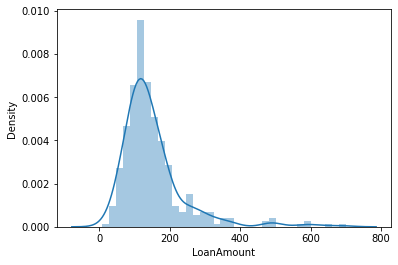

In [20]:
sns.distplot(df_train.LoanAmount)
df_train.LoanAmount.median(), df_train.LoanAmount.mean()

#can you guys help me fill in the LoanAmount with median()
df_train['LoanAmount'].fillna(df_train['LoanAmount'].median(), inplace=True)

df_train.isna().sum()


In [21]:
df_train.dtypes
#recall we want to use education, credit history, property area

Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status            int64
dtype: object

In [22]:
df_train.Education.unique()      #have to encode it to 0 and 1  #Ex1
df_train.Property_Area.unique()  #have to one-hot encode into three columns #Ex2

#why one-hot encode Property Area, not encode it into 0, 1, 2
#if we have more than two categories, if we encode into 0, 1, 2
#we create a unintentional order, i.e., the model "may" think that 0 < 1 < 2


array(['Semiurban', 'Rural', 'Urban'], dtype=object)

In [23]:
#hint Ex1: LabelEncoder(), map
df_train['Education'] = le.fit_transform(df_train['Education'])
le.inverse_transform([0, 1]) #hint Ex2: sklearn.preprocessing OneHotEncoder or pd.get_dummies

array(['Graduate', 'Not Graduate'], dtype=object)

In [24]:
df_train.columns

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [25]:
df_train.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
294,Male,Yes,0,0,No,2383,3334.0,172.0,360.0,1.0,Semiurban,1
501,Female,No,0,0,No,3159,0.0,100.0,360.0,1.0,Semiurban,1
323,Female,No,0,0,No,3166,2985.0,132.0,360.0,1.0,Rural,1
467,NaN,Yes,0,0,No,16692,0.0,110.0,360.0,1.0,Semiurban,1
476,Male,Yes,2,0,No,6700,1750.0,230.0,300.0,1.0,Semiurban,1


In [26]:
#hint Ex2: sklearn.preprocessing OneHotEncoder or pd.get_dummies
df_train = pd.get_dummies(df_train, columns=['Property_Area'])
df_train.head()

#another possible code
# from sklearn.preprocessing import OneHotEncoder

# ohe = OneHotEncoder(sparse=False)  #if sparse =True, it will shrink it
# df_train_ohe_property_area = pd.DataFrame(ohe.fit_transform(df_train[['Property_Area']]), index=df_train.index)

# #check how it looks like
# print(ohe.inverse_transform([ [1, 0, 0], [0, 1, 0], [0, 0, 1]]))

# df_train_ohe_property_area.columns = ['Rural', 'Semiurban', 'Urban']

# df_train = df_train.join(df_train_ohe_property_area)


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
294,Male,Yes,0,0,No,2383,3334.0,172.0,360.0,1.0,1,0,1,0
501,Female,No,0,0,No,3159,0.0,100.0,360.0,1.0,1,0,1,0
323,Female,No,0,0,No,3166,2985.0,132.0,360.0,1.0,1,1,0,0
467,NaN,Yes,0,0,No,16692,0.0,110.0,360.0,1.0,1,0,1,0
476,Male,Yes,2,0,No,6700,1750.0,230.0,300.0,1.0,1,0,1,0
